In [1]:
# 필요한 기본 패키지 준비

# 데이터 처리 필요 패키지
import numpy as np
import pandas as pd
import datetime as dt

# 시각화 필요 패키지
%matplotlib inline
from plotnine import *
import folium
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import seaborn as sns

# Machine Learning 분석 환경 준비

# 전처리, 스케일링
from sklearn.preprocessing import StandardScaler

# 선형회귀분석
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# OLS회귀분석
import statsmodels.api as sm

# GAM 일반화가법모형
# LinearGAM, LogisticGAM, PoissonGAM, GammaGAM, InvGuss
from pygam import LinearGAM, LogisticGAM, PoissonGAM, GammaGAM

# Boosting

#데이터셋 분리
from sklearn.model_selection import train_test_split



# 한글 처리
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# jupyter notebook에서 warning 무시하기
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, sns전체 데이터)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
social_all = pd.read_csv('D:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# 전처리 및 서울시로 통합된 날씨 데이터 불러오기
w_all_seoul = pd.read_csv('D:/project/contest/data/processed/p_wUVair_seoul.csv', index_col=[0], parse_dates=['date'])

In [3]:
gs_seoul = gs.loc[gs['pvn_nm']=='서울특별시']
lv_seoul = lv.loc[lv['pvn_nm']=='서울특별시']
# gs/lv데이터와 겹치는 columns=['year', 'month', 'day', 'nth_week','weekday'] 제거 
w_all_seoul = w_all_seoul.drop(columns=['year', 'month', 'day', 'nth_week','weekday'])

In [4]:
# 소셜데이터 합치기
%time ds_gs_seoul = gs_seoul.merge(social_all, on='date',how='left')
%time ds_lv_seoul = lv_seoul.merge(social_all, on='date',how='left')

Wall time: 681 ms
Wall time: 248 ms


## 분석시작

In [5]:
print('gs/lv 컬럼들')
print(list(ds_gs_seoul.columns)) # 33개 컬럼
print(list(ds_lv_seoul.columns)) # 33개 컬럼

print(' ')
print('날씨 데이터 컬럼들')
print(list(w_all_seoul.columns)) # 18개 컬럼

gs/lv 컬럼들
['pvn_nm', 'bor_nm', 'sale_dt', 'gender', 'age_cd', 'category', 'qty', 'year', 'month', 'day', 'date', 'weekday', 'nth_week', 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total', 'health_blog', 'health_twitter', 'health_news', 'health_total', 'date_blog', 'date_twitter', 'date_news', 'date_total', 'br_blog', 'br_twitter', 'br_news', 'br_total', 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
['pvn_nm', 'bor_nm', 'sale_dt', 'gender', 'age_cd', 'category', 'qty', 'year', 'month', 'day', 'date', 'weekday', 'nth_week', 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total', 'health_blog', 'health_twitter', 'health_news', 'health_total', 'date_blog', 'date_twitter', 'date_news', 'date_total', 'br_blog', 'br_twitter', 'br_news', 'br_total', 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
 
날씨 데이터 컬럼들
['loc', 'date', 'temp', 'rain', 'cloud', 'wind', 'humid', 'hpa', 'sun_time', 'lgt_time', 'snow', 'uv', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', 'rain_or_not', 'snow_or_not'

### 필요없는 열(columns)제거

In [6]:
# eliminating unnecessary columns
# 'loc', 'pvn_nm' : 이미 서울로 추렸으니 필요없다.
# 'sale_dt' : 'date' 컬럼이 있으니 필요없다.
ds_gs_seoul=ds_gs_seoul.drop(columns=['pvn_nm','sale_dt'])
ds_lv_seoul=ds_lv_seoul.drop(columns=['pvn_nm','sale_dt'])
w_all_seoul=w_all_seoul.drop(columns=['loc'])

### 2016년

In [7]:
print(list(ds_lv_seoul['category'].unique()))
print(list(ds_gs_seoul['category'].unique()))

['립컬러', '립케어', '마스크팩', '바디로션', '체중조절', '크림로션', '훼이셜클렌저', '선케어', '네일', '제모제']
['라면', '과자', '마스크', '맥주', '생리대', '생수', '숙취해소제', '스타킹', '아이스크림', '탄산음료', '면도기', '우산']


In [8]:
dfl1 = ds_lv_seoul.loc[ds_lv_seoul['year']==2016
                      ,['date','bor_nm','gender','age_cd','category','qty','year','month','nth_week','weekday']]
dfw1 = w_all_seoul.loc[ds_lv_seoul['date'].dt.year==2016]

dfl1_month = dfl1[['month','category','qty']].groupby(by=['month','category']).sum().reset_index()
# dfl1_month.head(2)
dfl1_week = dfl1[['nth_week','category','qty']].groupby(by=['nth_week','category']).sum().reset_index()
# dfl1_week.head(2)
dfw1['nth_week'] = dfw1['date'].dt.week
dfw1_week = dfw1[['nth_week','temp', 'rain', 'cloud', 'wind', 'humid', 'hpa', 'sun_time', 'lgt_time', 'snow', 'uv'
                  ,'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25']].groupby(by=['nth_week']).mean().reset_index()

# dfw1_week.head()
dfw1_week.corr()

,nth_week,temp,rain,cloud,wind,humid,hpa,sun_time,lgt_time,snow,uv,SO2,CO,O3,NO2,PM10,PM25
nth_week,1.000000,0.200596,0.045672,0.265666,-0.703893,0.367013,0.033554,-0.190713,-0.395080,-0.060565,-0.342392,-0.432618,0.049780,-0.312111,-0.106101,-0.331082,-0.258778
temp,0.200596,1.000000,0.504937,0.579317,-0.376377,0.663742,-0.927305,0.863848,0.218751,-0.552929,0.873245,-0.769750,-0.830682,0.715418,-0.718025,-0.523283,-0.508741
rain,0.045672,0.504937,1.000000,0.715000,-0.166607,0.649068,-0.546646,0.524197,-0.327274,-0.210015,0.325492,-0.407897,-0.463616,0.276054,-0.462457,-0.377414,-0.334213
cloud,0.265666,0.579317,0.715000,1.000000,-0.318209,0.899852,-0.563098,0.463095,-0.555020,-0.238386,0.357635,-0.400810,-0.344054,0.200094,-0.421729,-0.303070,-0.201549
wind,-0.703893,-0.376377,-0.166607,-0.318209,1.000000,-0.488888,0.123054,-0.020804,0.285000,0.156944,0.075022,0.385076,0.005951,0.189532,0.057982,0.326448,0.148892
humid,0.367013,0.663742,0.649068,0.899852,-0.488888,1.000000,-0.599008,0.455695,-0.477006,-0.284450,0.432116,-0.482257,-0.364268,0.181149,-0.477337,-0.411374,-0.264750
hpa,0.033554,-0.927305,-0.546646,-0.563098,0.123054,-0.599008,1.000000,-0.933460,-0.257550,0.488368,-0.931300,0.635820,0.829507,-0.812918,0.706970,0.413863,0.428510
sun_time,-0.190713,0.863848,0.524197,0.463095,-0.020804,0.455695,-0.933460,1.000000,0.409057,-0.488420,0.954119,-0.508473,-0.815811,0.912717,-0.599450,-0.255162,-0.302875
lgt_time,-0.395080,0.218751,-0.327274,-0.555020,0.285000,-0.477006,-0.257550,0.409057,1.000000,-0.164527,0.348090,-0.088115,-0.377873,0.639221,-0.108200,0.088635,-0.048728
snow,-0.060565,-0.552929,-0.210015,-0.238386,0.156944,-0.284450,0.488368,-0.488420,-0.164527,1.000000,-0.316345,0.360113,0.436458,-0.457120,0.271009,0.161905,0.262829


In [9]:
import missingno as msno

[Text(0.5, 0, 'nth_week'),
 Text(1.5, 0, 'temp'),
 Text(2.5, 0, 'rain'),
 Text(3.5, 0, 'cloud'),
 Text(4.5, 0, 'wind'),
 Text(5.5, 0, 'humid'),
 Text(6.5, 0, 'hpa'),
 Text(7.5, 0, 'sun_time'),
 Text(8.5, 0, 'lgt_time'),
 Text(9.5, 0, 'snow'),
 Text(10.5, 0, 'uv'),
 Text(11.5, 0, 'SO2'),
 Text(12.5, 0, 'CO'),
 Text(13.5, 0, 'O3'),
 Text(14.5, 0, 'NO2'),
 Text(15.5, 0, 'PM10'),
 Text(16.5, 0, 'PM25')]

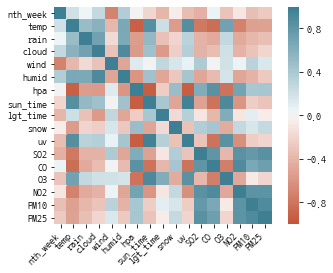

In [10]:
# 변수간의 관계를 나타내는 히트맵
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

corr = dfw1_week.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

# 썬케어 제품 분석

In [11]:
# lv물품
# ['립컬러', '립케어', '마스크팩', '바디로션', '체중조절', '크림로션', '훼이셜클렌저'
# , '선케어', '네일', '제모제']

# '선케어'
item = '선케어'

dflw_week = pd.merge(dfl1_week.loc[dfl1_week['category']==item], dfw1_week, on='nth_week', how='left') 
dflw_week.head(2)

,nth_week,category,qty,temp,rain,cloud,wind,humid,hpa,sun_time,lgt_time,snow,uv,SO2,CO,O3,NO2,PM10,PM25
0,1,선케어,5142,-0.190909,0.013636,3.740909,1.977273,51.050000,1014.459091,9.686364,6.745455,0.000000,NaN,0.005694,0.687988,0.011722,0.038706,50.291201,29.704881
1,2,선케어,4604,-3.833333,0.152381,3.342857,2.428571,50.714286,1011.752381,9.809524,6.552381,0.214286,NaN,0.005353,0.598826,0.013929,0.034002,45.275795,25.468847


In [12]:
dflw_week.corr()

,nth_week,qty,temp,rain,cloud,wind,humid,hpa,sun_time,lgt_time,snow,uv,SO2,CO,O3,NO2,PM10,PM25
nth_week,1.000000,-0.082131,0.200596,0.045672,0.265666,-0.703893,0.367013,0.033554,-0.190713,-0.395080,-0.060565,-0.342392,-0.432618,0.049780,-0.312111,-0.106101,-0.331082,-0.258778
qty,-0.082131,1.000000,0.625160,0.342151,0.244455,-0.058422,0.261038,-0.701715,0.773360,0.452605,-0.310706,0.698753,-0.312786,-0.576667,0.701017,-0.401612,-0.164030,-0.190537
temp,0.200596,0.625160,1.000000,0.504937,0.579317,-0.376377,0.663742,-0.927305,0.863848,0.218751,-0.552929,0.873245,-0.769750,-0.830682,0.715418,-0.718025,-0.523283,-0.508741
rain,0.045672,0.342151,0.504937,1.000000,0.715000,-0.166607,0.649068,-0.546646,0.524197,-0.327274,-0.210015,0.325492,-0.407897,-0.463616,0.276054,-0.462457,-0.377414,-0.334213
cloud,0.265666,0.244455,0.579317,0.715000,1.000000,-0.318209,0.899852,-0.563098,0.463095,-0.555020,-0.238386,0.357635,-0.400810,-0.344054,0.200094,-0.421729,-0.303070,-0.201549
wind,-0.703893,-0.058422,-0.376377,-0.166607,-0.318209,1.000000,-0.488888,0.123054,-0.020804,0.285000,0.156944,0.075022,0.385076,0.005951,0.189532,0.057982,0.326448,0.148892
humid,0.367013,0.261038,0.663742,0.649068,0.899852,-0.488888,1.000000,-0.599008,0.455695,-0.477006,-0.284450,0.432116,-0.482257,-0.364268,0.181149,-0.477337,-0.411374,-0.264750
hpa,0.033554,-0.701715,-0.927305,-0.546646,-0.563098,0.123054,-0.599008,1.000000,-0.933460,-0.257550,0.488368,-0.931300,0.635820,0.829507,-0.812918,0.706970,0.413863,0.428510
sun_time,-0.190713,0.773360,0.863848,0.524197,0.463095,-0.020804,0.455695,-0.933460,1.000000,0.409057,-0.488420,0.954119,-0.508473,-0.815811,0.912717,-0.599450,-0.255162,-0.302875
lgt_time,-0.395080,0.452605,0.218751,-0.327274,-0.555020,0.285000,-0.477006,-0.257550,0.409057,1.000000,-0.164527,0.348090,-0.088115,-0.377873,0.639221,-0.108200,0.088635,-0.048728


[Text(0.5, 0, 'qty'),
 Text(1.5, 0, 'temp'),
 Text(2.5, 0, 'rain'),
 Text(3.5, 0, 'cloud'),
 Text(4.5, 0, 'wind'),
 Text(5.5, 0, 'humid'),
 Text(6.5, 0, 'hpa'),
 Text(7.5, 0, 'sun_time'),
 Text(8.5, 0, 'lgt_time'),
 Text(9.5, 0, 'snow'),
 Text(10.5, 0, 'uv'),
 Text(11.5, 0, 'SO2'),
 Text(12.5, 0, 'CO'),
 Text(13.5, 0, 'O3'),
 Text(14.5, 0, 'NO2'),
 Text(15.5, 0, 'PM10'),
 Text(16.5, 0, 'PM25')]

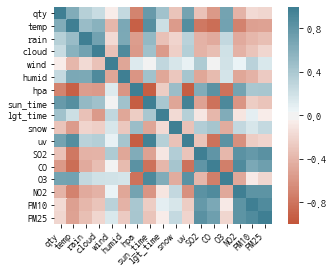

In [13]:
corr = dflw_week.iloc[:,1:].corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

### 간단한 시각화

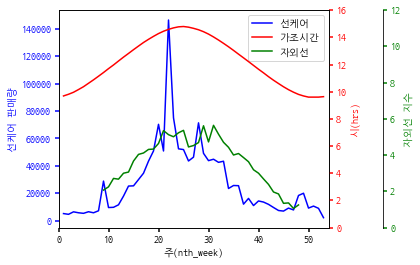

In [14]:
# https://matplotlib.org/gallery/ticks_and_spines/multiple_yaxis_with_spines.html

import matplotlib.pyplot as plt


def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot(dflw_week['nth_week'], dflw_week['qty'], "b-", label=item)
p2, = par1.plot(dflw_week['nth_week'], dflw_week['sun_time'], "r-", label="가조시간")
p3, = par1.plot(dflw_week['nth_week'], dflw_week['uv'], "g-", label="자외선")


host.set_xlim(0, 54)
par1.set_ylim(0, 16)
par2.set_ylim(0, 12)


host.set_xlabel("주(nth_week)")
host.set_ylabel(item+" 판매량")
par1.set_ylabel("시(hrs)")
par2.set_ylabel("자외선 지수")


host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())


tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines])

plt.show()

In [15]:
dflw_week['qty_scale'] = dflw_week['qty'].apply(lambda x : x/10000)

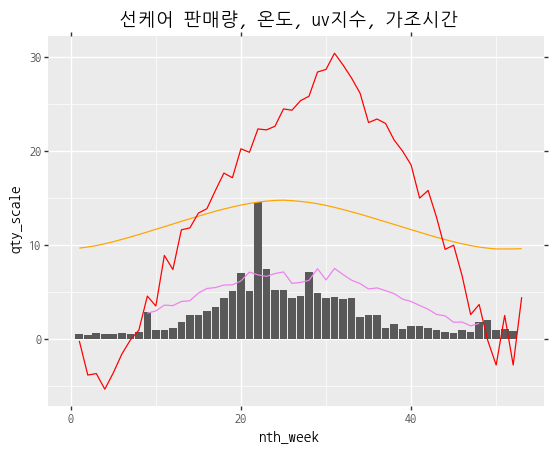

<ggplot: (115297628413)>

In [16]:
(ggplot(dflw_week, aes(x='nth_week',y='qty_scale'))
+ geom_bar(stat='identity',position='dodge')
+ geom_line(dflw_week, (aes(x='nth_week',y='sun_time')), color='orange')
+ geom_line(dflw_week, (aes(x='nth_week',y='uv')), color='violet')
+ geom_line(dflw_week, (aes(x='nth_week',y='temp')), color='red')
+ theme(text=element_text(family='NanumGothicCoding'))
+ ggtitle(item+' 판매량, 온도, uv지수, 가조시간')
+ xlim(0,53))

In [17]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [18]:
# # modeling 함수로 만들어 처리하기
# def linReg(df, item):
#     col_to_use = ['temp','humid','wind','rain','snow','cloud','sun_time'
#                  ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
#     X = df.loc[df['category']==item,col_to_use]
#     y = df.loc[df['category']==item,'qty']

#     X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

#     linReg = LinearRegression().fit(X_train, y_train)
  
#     print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
#     print('훈련세트점수 : {:.2f}'.format(linReg.score(X_train, y_train)))
#     print('검증세트점수 : {:.2f}'.format(linReg.score(X_test, y_test)))

    
# def ridgeReg(df, item):
#     col_to_use = ['temp','humid','wind','rain','snow','cloud','sun_time'
#                  ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
#     X = df.loc[df['category']==item,col_to_use]
#     y = df.loc[df['category']==item,'qty']

#     X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

#     ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
#     print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
#     print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
#     print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


# def lassoReg(df, item):
#     col_to_use = ['temp','humid','wind','rain','snow','cloud','sun_time'
#                  ,'pm.total', 'health.total','br.total', 'hobby.total','date.total']
#     X = df.loc[df['category']==item,col_to_use]
#     y = df.loc[df['category']==item,'qty']

#     X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

#     lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
#     print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
#     print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
#     print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

#     #사용한 특성수
#     print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )

In [19]:
dflw_week.columns

Index(['nth_week', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind', 'humid',
       'hpa', 'sun_time', 'lgt_time', 'snow', 'uv', 'SO2', 'CO', 'O3', 'NO2',
       'PM10', 'PM25', 'qty_scale'],
      dtype='object')

In [20]:
# uv가 null인 13주분량의 데이터는 제외
# print(dflw_week.isnull().sum())
dflw_week_noNull = dflw_week.loc[dflw_week['uv'].notnull()]
# print(dflw_week_noNull.isnull().sum())

In [21]:
# linear, rideg, lasso용
train_col = ['temp', 'uv','sun_time','O3','hpa']
# train_col = ['temp', 'rain', 'cloud', 'wind', 'humid', 'hpa', 'sun_time', 'lgt_time', 'snow', 'uv'
#              , 'SO2', 'CO', 'O3', 'NO2','PM10', 'PM25']
answer_col = ['qty']
X_train, X_test, y_train, y_test = train_test_split(dflw_week_noNull[train_col], dflw_week_noNull[answer_col]
                                                    , test_size=0.3, random_state=1111)

model = LinearRegression().fit(X_train, y_train)

# print('쓰인 열(columns) :',train_col)
# print('상수 값 : ',model.coef_)

predicted_f = ''
for idx in range(0,len(model.coef_[0])):
    predicted_f += "{:.2f}".format(model.coef_[0][idx])+"*'%s'"%train_col[idx]
    if (idx != (len(model.coef_[0])-1)):
        predicted_f += " + "
    else:
        predicted_f += " = '%s qty'"%item
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'% item)
print('공식 : ',predicted_f)
print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

LinearRegression을 이용한 선케어의 회귀분석 결과 :
공식 :  -1444.32*'temp' + 8433.20*'uv' + 15907.55*'sun_time' + -632013.96*'O3' + 1008.36*'hpa' = '선케어 qty'
훈련세트점수 : 0.57
검증세트점수 : -0.55


In [22]:
# 썬케어
# experiment_mo = sm.OLS.from_formula("qty ~ temp + rain + cloud", data=df_train)
ols_model = sm.OLS.from_formula("qty ~ temp + sun_time + O3 + hpa + uv", data=dflw_week_noNull)
print(ols_model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     8.932
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           1.71e-05
Time:                        15:51:19   Log-Likelihood:                -447.17
No. Observations:                  40   AIC:                             906.3
Df Residuals:                      34   BIC:                             916.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.076e+06   1.84e+06     -0.584      0.5

In [63]:
olsModel = ols_model.fit()
variables  = ols_model.exog_names

In [67]:
new_qty = olsModel.predict(dflw_week_noNull[variables[1:]])

# GS 마스크와 대기오염물질

In [142]:
# gs물품
# ['라면', '과자', '마스크', '맥주', '생리대', '생수', '숙취해소제', '스타킹'
# ,'아이스크림', '탄산음료', '면도기', '우산']
dfg1 = ds_gs_seoul.loc[ds_gs_seoul['year']==2016
                      ,['date','bor_nm','gender','age_cd','category','qty','year','month','nth_week','weekday']]

# 월 단위 종합 테이블
dfg1_month = dfg1[['month','category','qty','bor_nm']].groupby(by=['month','category','bor_nm']).sum().reset_index()
dfg1_month.head(2)

# 주단위 종합 테이블
dfg1_week = dfg1[['nth_week','category','qty']].groupby(by=['nth_week','category']).sum().reset_index()
dfg1_week.head(2)

,nth_week,category,qty
0,1,과자,270013
1,1,라면,162316


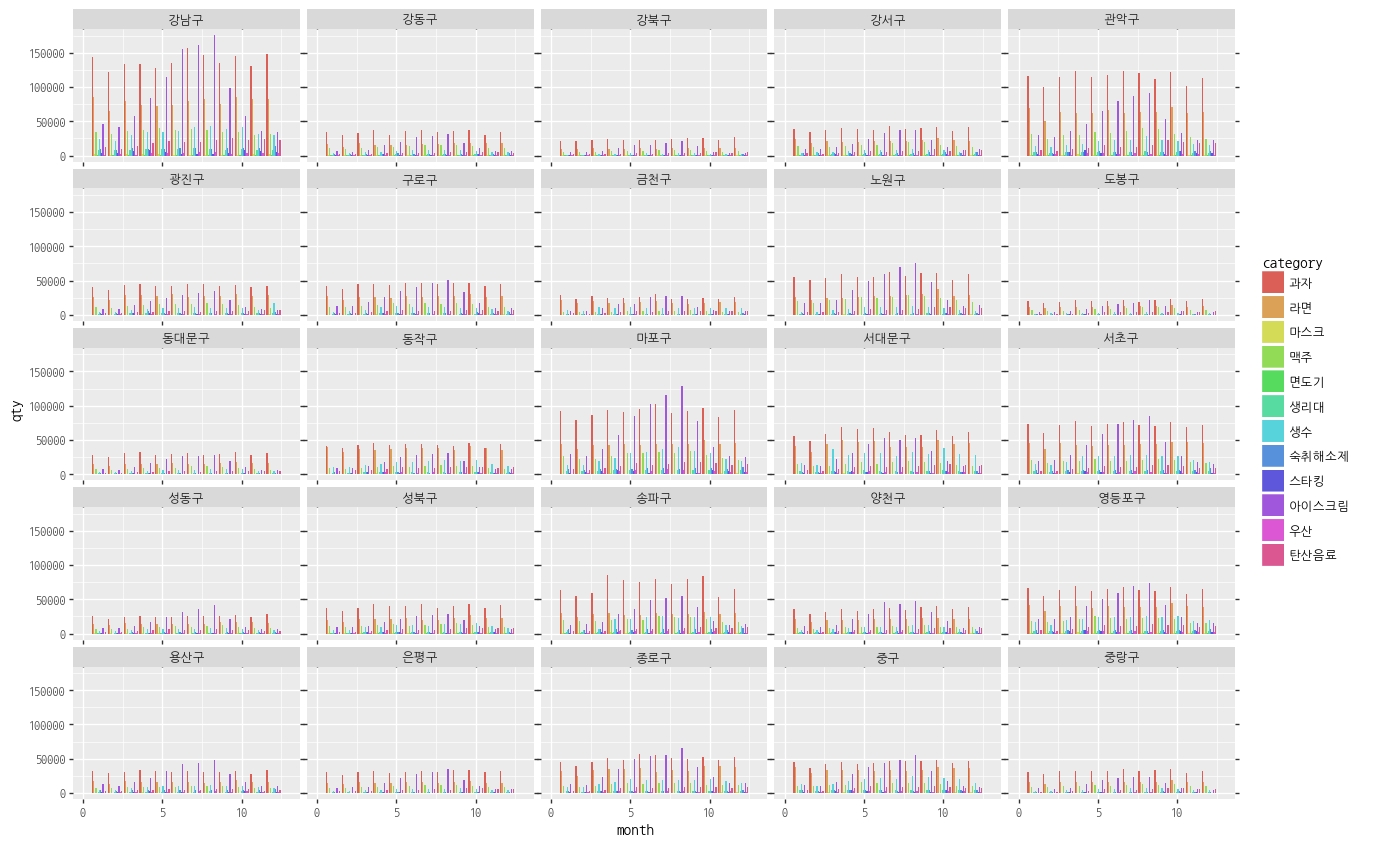

<ggplot: (-9223371892167623508)>

In [143]:
# 월단위 종합테이블, 물품판매량 각 행정구단위 그래프
(ggplot(dfg1_month, aes(x='month',y='qty',fill='category'))
+ geom_bar(stat='identity',position='dodge')
+ theme(text=element_text(family='NanumGothicCoding'), figure_size = (15,10))
+ facet_wrap('bor_nm')
+ xlim(0,13)
)

In [144]:
df_fun = dfg1[['bor_nm','qty','category']].groupby(['bor_nm','category']).sum().reset_index()
df_fun= df_fun.sort_values('qty',ascending=False).reset_index()
df_fun.drop(columns='index',inplace=True)
df_fun.head(3)

,bor_nm,category,qty
0,강남구,과자,1657564
1,관악구,과자,1376149
2,마포구,과자,1096357


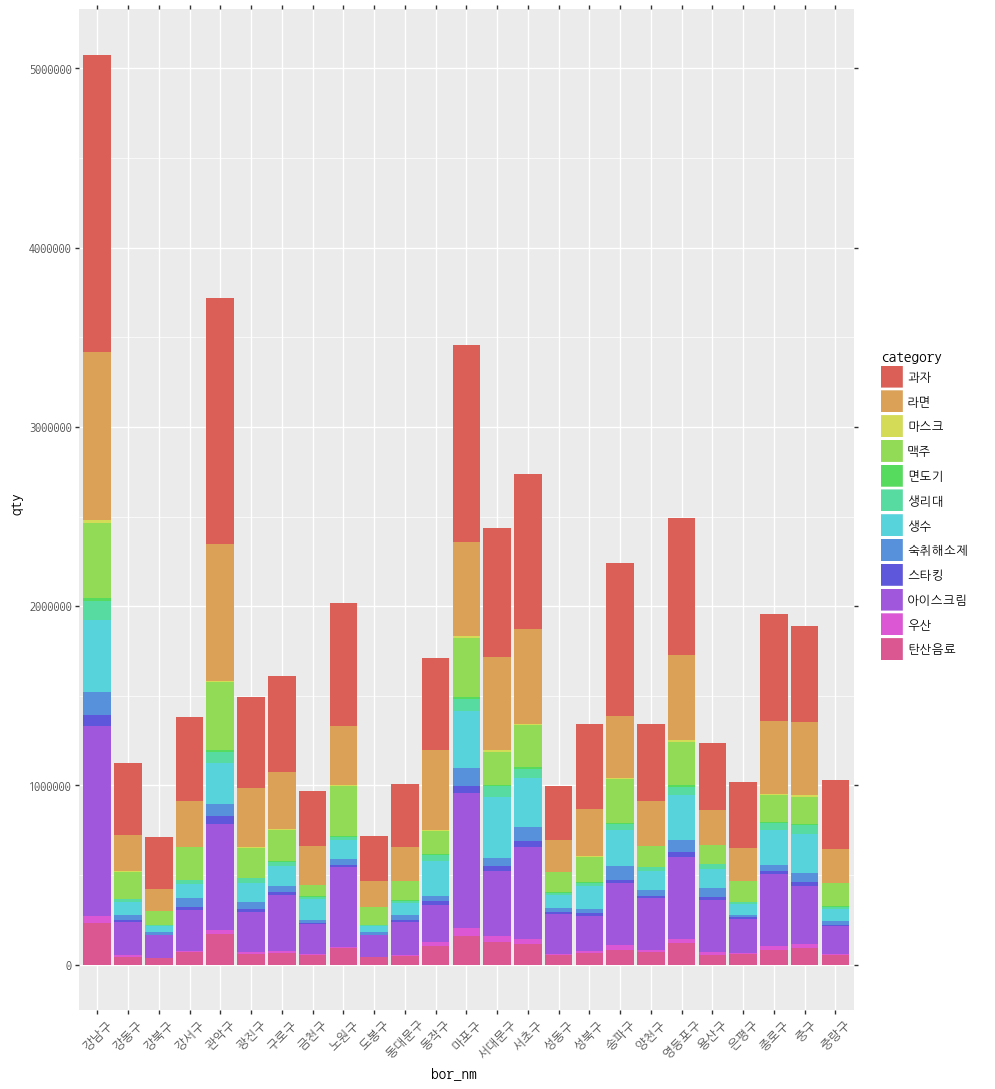

<ggplot: (144692748499)>

In [145]:
# 2016년 행정구단위 판매량 종합
# (ggplot(df_fun, aes(x='bor_nm',y='qty',fill='category'))
(ggplot(df_fun, aes(x='bor_nm',y='qty', fill='category'))
# + geom_bar(stat='identity',position = 'dodge')
+ geom_bar(stat='identity')
+ theme(text=element_text(family='NanumGothicCoding'), figure_size = (10,13))
+ theme(axis_text_x = element_text(angle = 45))
# + coord_flip()
)

# 마스크

In [146]:
# 마스크
item='마스크'
dfgw_week = pd.merge(dfg1_week.loc[dfg1_week['category']==item], dfw1_week, on='nth_week', how='left') 
dfgw_week.head(2)

,nth_week,category,qty,temp,rain,cloud,wind,humid,hpa,sun_time,lgt_time,snow,uv,SO2,CO,O3,NO2,PM10,PM25
0,1,마스크,1974,2.509740,0.160390,4.041558,2.040260,55.250000,1015.818831,9.807792,6.251948,0.003247,NaN,0.005694,0.687988,0.011722,0.038706,50.291201,29.704881
1,2,마스크,1694,-0.919728,0.557823,3.585034,2.563265,56.422449,1013.168027,9.925170,6.539456,0.393878,NaN,0.005353,0.598826,0.013929,0.034002,45.275795,25.468847


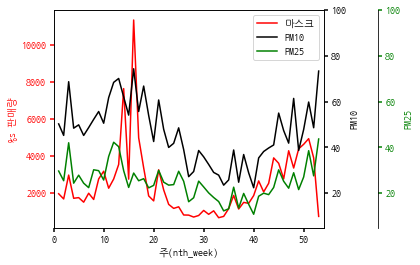

In [93]:
# https://matplotlib.org/gallery/ticks_and_spines/multiple_yaxis_with_spines.html

fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

# 'PM10', 'PM25'

p1, = host.plot(dfgw_week['nth_week'], dfgw_week['qty'], "r-", label=item)
p2, = par1.plot(dfgw_week['nth_week'], dfgw_week['PM10'], "k-", label="PM10")
p3, = par2.plot(dfgw_week['nth_week'], dfgw_week['PM25'], "g-", label="PM25")


host.set_xlim(0, 54)
par1.set_ylim(5, 100)
par2.set_ylim(5, 100)


host.set_xlabel("주(nth_week)")
host.set_ylabel("%s 판매량".format(item))
par1.set_ylabel("PM10")
par2.set_ylabel("PM25")


host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())


tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines])

plt.show()

[Text(0.5, 0, 'nth_week'),
 Text(1.5, 0, 'qty'),
 Text(2.5, 0, 'temp'),
 Text(3.5, 0, 'rain'),
 Text(4.5, 0, 'cloud'),
 Text(5.5, 0, 'wind'),
 Text(6.5, 0, 'humid'),
 Text(7.5, 0, 'hpa'),
 Text(8.5, 0, 'sun_time'),
 Text(9.5, 0, 'lgt_time'),
 Text(10.5, 0, 'snow'),
 Text(11.5, 0, 'uv'),
 Text(12.5, 0, 'SO2'),
 Text(13.5, 0, 'CO'),
 Text(14.5, 0, 'O3'),
 Text(15.5, 0, 'NO2'),
 Text(16.5, 0, 'PM10'),
 Text(17.5, 0, 'PM25')]

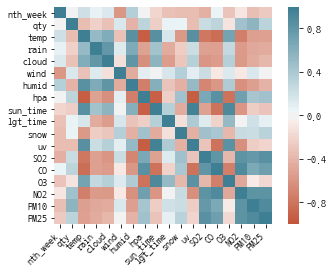

In [147]:
corr = dfgw_week.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [148]:
dfgw_week.corr()

,nth_week,qty,temp,rain,cloud,wind,humid,hpa,sun_time,lgt_time,snow,uv,SO2,CO,O3,NO2,PM10,PM25
nth_week,1.000000,0.015539,0.211037,0.078029,0.140665,-0.584166,0.358978,0.021283,-0.190910,-0.320693,-0.340413,-0.342392,-0.434215,0.047393,-0.311687,-0.108122,-0.335357,-0.264664
qty,0.015539,1.000000,-0.347092,-0.224322,-0.323178,0.152911,-0.418109,0.305676,-0.234446,0.069732,0.058101,-0.348561,0.245405,0.303069,-0.116245,0.449058,0.557956,0.320133
temp,0.211037,-0.347092,1.000000,0.512028,0.635172,-0.325067,0.838753,-0.930761,0.856190,0.161310,-0.576853,0.856846,-0.779611,-0.833226,0.697883,-0.729694,-0.537659,-0.522528
rain,0.078029,-0.224322,0.512028,1.000000,0.796802,0.118843,0.646029,-0.514528,0.444243,-0.452025,-0.257282,0.231232,-0.526216,-0.521603,0.278177,-0.562447,-0.470493,-0.458435
cloud,0.140665,-0.323178,0.635172,0.796802,1.000000,-0.125013,0.808854,-0.622272,0.556327,-0.544415,-0.290523,0.349132,-0.591899,-0.553041,0.345331,-0.572335,-0.446449,-0.384903
wind,-0.584166,0.152911,-0.325067,0.118843,-0.125013,1.000000,-0.459905,0.093740,-0.000739,0.157132,0.359102,0.098879,0.232060,-0.079022,0.136625,-0.080398,0.153619,-0.016176
humid,0.358978,-0.418109,0.838753,0.646029,0.808854,-0.459905,1.000000,-0.731524,0.601398,-0.300516,-0.436087,0.509542,-0.686931,-0.579683,0.367855,-0.611736,-0.532412,-0.408743
hpa,0.021283,0.305676,-0.930761,-0.514528,-0.622272,0.093740,-0.731524,1.000000,-0.928412,-0.229831,0.446525,-0.929719,0.657171,0.842956,-0.807123,0.724511,0.435250,0.448123
sun_time,-0.190910,-0.234446,0.856190,0.444243,0.556327,-0.000739,0.601398,-0.928412,1.000000,0.349520,-0.456491,0.954249,-0.507930,-0.815286,0.912589,-0.598224,-0.251747,-0.299079
lgt_time,-0.320693,0.069732,0.161310,-0.452025,-0.544415,0.157132,-0.300516,-0.229831,0.349520,1.000000,-0.125715,0.389111,0.119044,-0.213651,0.511659,0.007191,0.198194,0.084449


In [149]:
dfgw_week_noNull = dfgw_week.loc[(dfgw_week['PM10'].notnull())&(dfgw_week['PM25'].notnull())]

In [150]:
# linear, rideg, lasso용
# train_col = ['PM10', 'PM25']
train_col = ['rain', 'SO2', 'CO', 'O3', 'NO2','PM10','PM25']
answer_col = ['qty']
X_train, X_test, y_train, y_test = train_test_split(dfgw_week_noNull[train_col], dfgw_week_noNull[answer_col]
                                                    , test_size=0.3, random_state=1111)

model = LinearRegression().fit(X_train, y_train)
  
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'% item)
print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

LinearRegression을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.65
검증세트점수 : 0.26


In [151]:
model = Ridge().fit(X_train, y_train)
print('Ridge를 이용한 %s의 회귀분석 결과 :'% item)
print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

Ridge를 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.48
검증세트점수 : 0.26


In [152]:
model = Lasso().fit(X_train, y_train)
print('Lasso를 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

Lasso를 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.58
검증세트점수 : 0.10


In [245]:
ols_model = sm.OLS.from_formula("qty ~ rain + SO2 + CO + O3 + NO2 + PM10 + PM25", data=dfgw_week_noNull)
print(ols_model.fit().summary())
ols_model = sm.OLS.from_formula("qty ~ rain_cat + SO2 + O3 + PM10 + PM25", data=dfgw_week_noNull)
print(ols_model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     9.068
Date:                Tue, 09 Jul 2019   Prob (F-statistic):           6.21e-07
Time:                        15:54:29   Log-Likelihood:                -450.86
No. Observations:                  53   AIC:                             917.7
Df Residuals:                      45   BIC:                             933.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8647.7138   3528.161      2.451      0.0

## 마스크 데이터 예측의 r-square값을 향상 시키기 위한 데이터 전처리
### 각 데이터의 카테고리화 1
* rain 데이터 카테고리 화 : 0mm -> 0(맑음) , 0mm 이상 ->1(비옴), 30mm 이상 ->2(비많이 옴)

In [154]:
# 날씨중 rain 데이터 카테고리 화 : 0mm -> 0(맑음) , 0mm 이상 ->1(비옴), 30mm 이상 ->2(비많이 옴)
def rainCat(mm):
    if mm == 0:
        return 0
    if mm >= 30:
        return 2
    if mm > 0:
        return 1

w_all_seoul['rain_cat'] = w_all_seoul['rain'].apply(lambda x : rainCat(x))
w_all_seoul.loc[w_all_seoul['rain_cat']!=0].tail(2)

,date,temp,rain,cloud,wind,humid,hpa,sun_time,lgt_time,snow,uv,SO2,CO,O3,NO2,PM10,PM25,rain_cat
7651,2018-12-11,5.8,2.8,9.1,3.5,83.3,1016.3,9.8,0.0,0.0,NaN,0.004967,0.775744,0.004016,0.047279,43.049408,24.180251,1
7656,2018-12-16,4.7,4.4,7.0,2.4,66.9,1011.4,9.8,0.0,0.0,NaN,0.004980,0.891319,0.002998,0.051206,53.455104,40.721267,1
7663,2018-12-23,8.8,3.6,4.5,2.3,52.6,1012.3,9.8,5.1,0.0,NaN,0.004670,0.576502,0.021261,0.023654,51.540041,28.254889,1


### 각 데이터의 카테고리화 2
* snow 데이터 카테고리 화 : 0mm -> 0(맑음) , 0mm 이상 ->1(눈옴), 30mm 이상 ->2눈 많이 옴)

In [155]:
# 날씨중 snow 데이터 카테고리 화 : 0mm -> 0(맑음) , 0mm 이상 ->1(눈옴), 30mm 이상 ->2눈 많이 옴)
def snowCat(mm):
    if mm == 0:
        return 0
    if mm >= 30:
        return 2
    if mm > 0:
        return 1

w_all_seoul['snow_cat'] = w_all_seoul['snow'].apply(lambda x : snowCat(x))
w_all_seoul.loc[w_all_seoul['snow_cat']!=0].tail(2)

,date,temp,rain,cloud,wind,humid,hpa,sun_time,lgt_time,snow,uv,SO2,CO,O3,NO2,PM10,PM25,rain_cat,snow_cat
6254,2018-02-13,1.3,0.0,1.8,1.9,59.6,1015.4,10.9,9.9,0.6,NaN,0.005782,0.576929,0.015980,0.036768,51.887130,15.830220,0,1
6290,2018-03-21,2.3,6.6,10.0,2.5,96.1,1006.5,12.2,0.0,1.0,3.0,0.003377,0.381196,0.027962,0.023083,15.345708,6.877802,1,1
7316,2018-01-10,-0.7,0.2,2.1,4.1,51.9,1008.0,10.0,7.5,1.3,NaN,0.004619,0.414751,0.019202,0.020469,34.686926,14.558125,1,1


### 각 데이터의 카테고리화 3
* temp 데이터 카테고리 화 : -10이하 :0, 0이하 :1, 10도이하:2, 20도 이하: 3, 30도이하:4, 30도 초과 :5

In [229]:
# 날씨중 temp 데이터 카테고리 화 : -10이하 :0, 0이하 :1, 10도이하:2, 20도 이하: 3, 30도이하:4, 30도 초과 :5
def tempCat(temp):
    if temp >= 30.0:
        return 5
    if temp <= -10.0:
        return 0
    if (temp <30.0) & (temp>=20.0):
        return 4
    if (temp <20.0) & (temp >=10.0):
        return 3
    if (temp <10.0) & (temp >=0.0):
        return 2
    if (temp <0.0)  & (temp >= -10.0):
        return 1

w_all_seoul['temp_cat'] = w_all_seoul['temp'].apply(lambda x : tempCat(x))
w_all_seoul.loc[w_all_seoul['temp']!=0].tail(2)

,date,temp,rain,cloud,wind,humid,hpa,sun_time,lgt_time,snow,uv,SO2,CO,O3,NO2,PM10,PM25,rain_cat,snow_cat,temp_cat
7670,2018-12-30,-0.7,0.0,2.6,3.5,30.4,1025.4,9.8,8.8,0.0,NaN,0.004610,0.635120,0.011962,0.030831,32.547039,16.795456,0,0,1
7671,2018-12-31,3.9,0.0,6.1,2.4,36.5,1024.8,9.8,5.7,0.0,NaN,0.004698,0.853559,0.006310,0.045648,46.795434,28.973430,0,0,2


### 각 데이터의 카테고리화 4
* 미세먼지 농도를 활용해서 0,1,2,3(좋음, 보통, 나쁨, 매우나쁨) 카테고리 생성

In [230]:
# 미세먼지 농도를 활용해서 0,1,2,3(좋음, 보통, 나쁨, 매우나쁨) 카테고리 생성

# 서울시청 미세먼지 농도 기준
# https://bluesky.seoul.go.kr/finedust/common-sense/page/10?article=745


# ppm
# O3   |0~0.03|0.031~0.09|0.091~0.15|0.151~
def o3Cat(o3):
    if (o3<=0.03):
        return 0
    if (o3>0.03) & (o3<=0.09):
        return 1
    if (o3>0.09) & (o3<=0.15):
        return 2
    if (o3>0.15):
        return 3


# NO2  |0~0.03|0.031~0.06|0.061~0.2|0.201~
def no2Cat(no2):
    if (no2<=0.03):
        return 0
    if (no2>0.03) & (no2<=0.06):
        return 1
    if (no2>0.06) & (no2<=0.2):
        return 2
    if (no2>0.2):
        return 3

# CO     |0~2|2.01~9|9.01~15|15.01~
def coCat(co):
    if (co<=2):
        return 0
    if (co>2) & (co<=9):
        return 1
    if (co>9) & (co<=15):
        return 2
    if (co>15):
        return 3

# SO2    |0~0.02|0.021~0.05|0.051~0.15|0.151~
def s02Cat(so2):
    if (so2<=0.02):
        return 0
    if (so2>0.02) & (so2<=0.05):
        return 1
    if (so2>0.05) & (so2<=0.15):
        return 2
    if (so2>0.151):
        return 3


# (일평균,㎍/㎥)	예보 등급(일평균, ㎍/㎥)
# 			좋음		보통	나쁨	매우나쁨
# PM-2.5	0~15	16~35	36~75	76~
def ulFineD(pm25):
    if (pm25 >= 76):
        return 3
    if (pm25 >=36) & (pm25<76):
        return 2
    if (pm25 >=16) & (pm25<36):
        return 1
    if (pm25 >=0) & (pm25<16):
        return 0

# PM-10		0~30	31~80	81~100	151~
def fineD(pm10):
    if (pm10 >= 151):
        return 3
    if (pm10 >=80) & (pm10<100):
        return 2
    if (pm10 >=30) & (pm10<80):
        return 1
    if (pm10 >=0) & (pm10<30):
        return 0

In [233]:
dfgw_week_noNull['temp_cat'] = dfgw_week_noNull['temp'].apply(lambda x : tempCat(x))
dfgw_week_noNull['snow_cat'] = dfgw_week_noNull['snow'].apply(lambda x : snowCat(x))
dfgw_week_noNull['rain_cat'] = dfgw_week_noNull['rain'].apply(lambda x : rainCat(x))
dfgw_week_noNull['pm25_cat'] = dfgw_week_noNull['PM25'].apply(lambda x : ulFineD(x))
dfgw_week_noNull['pm10_cat'] = dfgw_week_noNull['PM10'].apply(lambda x : fineD(x))
dfgw_week_noNull['SO2_cat'] = dfgw_week_noNull['SO2'].apply(lambda x : s02Cat(x))
dfgw_week_noNull['CO_cat'] = dfgw_week_noNull['CO'].apply(lambda x : coCat(x))
dfgw_week_noNull['O3_cat'] = dfgw_week_noNull['O3'].apply(lambda x : o3Cat(x))
dfgw_week_noNull['NO2_cat'] = dfgw_week_noNull['NO2'].apply(lambda x : no2Cat(x))

train_col = ['rain_cat', 'SO2_cat', 'CO_cat', 'O3_cat', 'NO2_cat','pm10_cat','pm25_cat']
answer_col = ['qty']
X_train, X_test, y_train, y_test = train_test_split(dfgw_week_noNull[train_col], dfgw_week_noNull[answer_col]
                                                    , test_size=0.3, random_state=1111)

In [243]:
ols_model = sm.OLS.from_formula("qty ~ rain_cat + SO2 + O3 + PM10 + PM25", data=dfgw_week_noNull)
print(ols_model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     14.92
Date:                Tue, 09 Jul 2019   Prob (F-statistic):           9.21e-09
Time:                        15:52:04   Log-Likelihood:                -448.99
No. Observations:                  53   AIC:                             910.0
Df Residuals:                      47   BIC:                             921.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2060.2761   2621.968      0.786      0.4

In [236]:
# train_col = ['rain_cat', 'SO2', 'CO', 'O3', 'NO2','PM10_cat','PM25_cat']
train_col = ['rain_cat', 'snow_cat', 'SO2_cat', 'O3_cat', 'PM10_cat','PM25_cat']

answer_col = ['qty']
X_train, X_test, y_train, y_test = train_test_split(dfgw_week_noNull[train_col], dfgw_week_noNull[answer_col]
                                                    , test_size=0.3, random_state=1111)

In [237]:
model = LinearRegression().fit(X_train, y_train)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'% item)
print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

LinearRegression을 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.36
검증세트점수 : -0.03


In [238]:
model = Ridge().fit(X_train, y_train)
print('Ridge를 이용한 %s의 회귀분석 결과 :'% item)
print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

Ridge를 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.35
검증세트점수 : -0.04


In [239]:
model = Lasso().fit(X_train, y_train)
print('Lasso를 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

Lasso를 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.36
검증세트점수 : -0.03


In [241]:
ols_model = sm.OLS.from_formula("qty ~ rain_cat + SO2_cat + O3_cat + PM10_cat + PM25_cat", data=dfgw_week_noNull)
print(ols_model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     2.942
Date:                Tue, 09 Jul 2019   Prob (F-statistic):             0.0297
Time:                        15:40:52   Log-Likelihood:                -468.36
No. Observations:                  53   AIC:                             946.7
Df Residuals:                      48   BIC:                             956.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1280.6000   2071.176     -0.618      0.5

In [197]:
dfgw_week_noNull.head(10)

,nth_week,category,qty,temp,rain,cloud,wind,humid,hpa,sun_time,...,NO2,PM10,PM25,temp_cat,snow_cat,rain_cat,pm25_cat,pm10_cat,PM25_cat,PM10_cat
0,1,마스크,1974,2.509740,0.160390,4.041558,2.040260,55.250000,1015.818831,9.807792,...,0.038706,50.291201,29.704881,2,1,1,1,1,1,1
1,2,마스크,1694,-0.919728,0.557823,3.585034,2.563265,56.422449,1013.168027,9.925170,...,0.034002,45.275795,25.468847,1,1,1,1,1,1,1
2,3,마스크,2984,-0.827211,1.131973,4.317007,2.552381,58.193197,1015.523129,10.070748,...,0.040982,68.733596,42.057609,1,1,1,2,1,2,1
3,4,마스크,1729,-2.021088,1.228571,3.851020,2.494558,53.376871,1017.650340,10.252381,...,0.037523,48.430874,24.403052,1,1,1,1,1,1,1
4,5,마스크,1765,-0.705442,0.136735,2.570748,2.511565,48.051701,1016.417007,10.457823,...,0.038332,49.885707,27.895965,1,1,1,1,1,1,1
5,6,마스크,1519,0.944218,1.719728,3.906803,2.803401,53.706803,1012.406122,10.684354,...,0.034658,45.257062,24.390178,2,1,1,1,1,1,1
6,7,마스크,2002,2.563265,0.325170,3.648980,2.698639,50.316327,1014.591837,10.926531,...,0.035299,48.690618,22.452758,2,1,1,1,1,1,1
7,8,마스크,1666,3.459864,1.306122,4.486395,2.431293,53.344218,1015.653741,11.183673,...,0.037140,52.274988,30.254532,2,1,1,1,1,1,1
8,9,마스크,2776,6.356463,4.880272,4.486395,2.398639,61.012925,1011.200680,11.442177,...,0.042284,55.704636,29.861717,2,1,1,1,1,1,1
9,10,마스크,3193,5.089796,1.638095,4.316327,2.651020,55.472109,1012.668707,11.710204,...,0.033672,50.596624,25.774552,2,1,1,1,1,1,1


In [199]:
dfgw_week_noNull.corr()

,nth_week,qty,temp,rain,cloud,wind,humid,hpa,sun_time,lgt_time,...,NO2,PM10,PM25,temp_cat,snow_cat,rain_cat,pm25_cat,pm10_cat,PM25_cat,PM10_cat
nth_week,1.000000,0.015539,0.211037,0.078029,0.140665,-0.584166,0.358978,0.021283,-0.190910,-0.320693,...,-0.108122,-0.335357,-0.264664,0.250122,-0.251038,-0.235702,-0.186973,-0.203674,-0.186973,-0.203674
qty,0.015539,1.000000,-0.347092,-0.224322,-0.323178,0.152911,-0.418109,0.305676,-0.234446,0.069732,...,0.449058,0.557956,0.320133,-0.279509,0.149650,0.131881,0.186868,0.351174,0.186868,0.351174
temp,0.211037,-0.347092,1.000000,0.512028,0.635172,-0.325067,0.838753,-0.930761,0.856190,0.161310,...,-0.729694,-0.537659,-0.522528,0.953411,-0.825142,0.125688,-0.375109,-0.485701,-0.375109,-0.485701
rain,0.078029,-0.224322,0.512028,1.000000,0.796802,0.118843,0.646029,-0.514528,0.444243,-0.452025,...,-0.562447,-0.470493,-0.458435,0.472741,-0.374053,0.125068,-0.463649,-0.634763,-0.463649,-0.634763
cloud,0.140665,-0.323178,0.635172,0.796802,1.000000,-0.125013,0.808854,-0.622272,0.556327,-0.544415,...,-0.572335,-0.446449,-0.384903,0.603194,-0.470350,0.040876,-0.300125,-0.544069,-0.300125,-0.544069
wind,-0.584166,0.152911,-0.325067,0.118843,-0.125013,1.000000,-0.459905,0.093740,-0.000739,0.157132,...,-0.080398,0.153619,-0.016176,-0.316935,0.370994,0.286454,-0.109800,0.005802,-0.109800,0.005802
humid,0.358978,-0.418109,0.838753,0.646029,0.808854,-0.459905,1.000000,-0.731524,0.601398,-0.300516,...,-0.611736,-0.532412,-0.408743,0.771089,-0.715592,-0.140747,-0.255422,-0.555000,-0.255422,-0.555000
hpa,0.021283,0.305676,-0.930761,-0.514528,-0.622272,0.093740,-0.731524,1.000000,-0.928412,-0.229831,...,0.724511,0.435250,0.448123,-0.888894,0.719043,-0.178316,0.327737,0.420619,0.327737,0.420619
sun_time,-0.190910,-0.234446,0.856190,0.444243,0.556327,-0.000739,0.601398,-0.928412,1.000000,0.349520,...,-0.598224,-0.251747,-0.299079,0.836589,-0.686213,0.194787,-0.198980,-0.267246,-0.198980,-0.267246
lgt_time,-0.320693,0.069732,0.161310,-0.452025,-0.544415,0.157132,-0.300516,-0.229831,0.349520,1.000000,...,0.007191,0.198194,0.084449,0.176095,-0.164943,0.116427,0.089737,0.286313,0.089737,0.286313


[Text(0.5, 0, 'nth_week'),
 Text(1.5, 0, 'qty'),
 Text(2.5, 0, 'temp'),
 Text(3.5, 0, 'rain'),
 Text(4.5, 0, 'cloud'),
 Text(5.5, 0, 'wind'),
 Text(6.5, 0, 'humid'),
 Text(7.5, 0, 'hpa'),
 Text(8.5, 0, 'sun_time'),
 Text(9.5, 0, 'lgt_time'),
 Text(10.5, 0, 'snow'),
 Text(11.5, 0, 'uv'),
 Text(12.5, 0, 'SO2'),
 Text(13.5, 0, 'CO'),
 Text(14.5, 0, 'O3'),
 Text(15.5, 0, 'NO2'),
 Text(16.5, 0, 'PM10'),
 Text(17.5, 0, 'PM25'),
 Text(18.5, 0, 'temp_cat'),
 Text(19.5, 0, 'snow_cat'),
 Text(20.5, 0, 'rain_cat'),
 Text(21.5, 0, 'pm25_cat'),
 Text(22.5, 0, 'pm10_cat'),
 Text(23.5, 0, 'PM25_cat'),
 Text(24.5, 0, 'PM10_cat')]

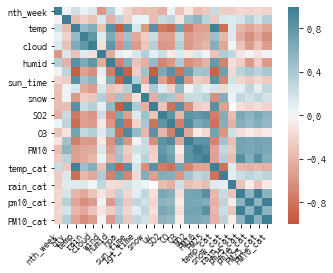

In [201]:
corr = dfgw_week_noNull.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [202]:
ols_model = sm.OLS.from_formula("qty ~ rain_cat + SO2 + O3 + PM10 + PM25", data=dfgw_week_noNull)
print(ols_model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     14.92
Date:                Tue, 09 Jul 2019   Prob (F-statistic):           9.21e-09
Time:                        14:14:02   Log-Likelihood:                -448.99
No. Observations:                  53   AIC:                             910.0
Df Residuals:                      47   BIC:                             921.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2060.2761   2621.968      0.786      0.4

In [213]:
predicted_f = ''
for idx in range(0,len(model.coef_[0])):
    predicted_f += "{:.2f}".format(model.coef_[0][idx])+"*'%s'"%train_col[idx]
    if (idx != (len(model.coef_[0])-1)):
        predicted_f += " + "
    else:
        predicted_f += " = '%s qty'"%item
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'% item)
print('공식 : ',predicted_f)
print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

LinearRegression을 이용한 마스크의 회귀분석 결과 :
공식 :  0.00*'rain_cat' + 440.57*'snow_cat' + -1.05*'SO2' + -155.66*'O3' + 101.55*'PM10' + -61.54*'PM25' = '마스크 qty'
훈련세트점수 : 0.46
검증세트점수 : 0.30


In [209]:
model = Lasso().fit(X_train, y_train)
print('Lasso를 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

Lasso를 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.62
검증세트점수 : 0.19


In [212]:
model = Ridge().fit(X_train, y_train)
print('Lasso를 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

Lasso를 이용한 마스크의 회귀분석 결과 :
훈련세트점수 : 0.46
검증세트점수 : 0.30


In [216]:
dflw_week.head(3)

,nth_week,category,qty,temp,rain,cloud,wind,humid,hpa,sun_time,lgt_time,snow,uv,SO2,CO,O3,NO2,PM10,PM25,qty_scale
0,1,선케어,5142,2.509740,0.160390,4.041558,2.040260,55.250000,1015.818831,9.807792,6.251948,0.003247,NaN,0.005694,0.687988,0.011722,0.038706,50.291201,29.704881,0.5142
1,2,선케어,4604,-0.919728,0.557823,3.585034,2.563265,56.422449,1013.168027,9.925170,6.539456,0.393878,NaN,0.005353,0.598826,0.013929,0.034002,45.275795,25.468847,0.4604
2,3,선케어,6414,-0.827211,1.131973,4.317007,2.552381,58.193197,1015.523129,10.070748,6.259864,0.641497,NaN,0.006035,0.748371,0.012695,0.040982,68.733596,42.057609,0.6414


In [218]:
gs_social = pd.read_csv('d:/project/contest/data/processed/gs_social.csv')

In [220]:
gs_social.columns

Index(['date', 'gender', 'category', 'qty', 'nth_week', 'pm.blog',
       'pm.twitter', 'pm.news', 'pm.total', 'health.blog', 'health.twitter',
       'health.news', 'health.total', 'date.blog', 'date.twitter', 'date.news',
       'date.total', 'br.blog', 'br.twitter', 'br.news', 'br.total',
       'hobby.blog', 'hobby.twitter', 'hobby.news', 'hobby.total'],
      dtype='object')

In [222]:
df_s_gs_week = gs_social.groupby(by=['nth_week','category']).sum().reset_index()

In [226]:
df_s_gs_week.corr()

,nth_week,qty,pm.blog,pm.twitter,pm.news,pm.total,health.blog,health.twitter,health.news,health.total,...,date.news,date.total,br.blog,br.twitter,br.news,br.total,hobby.blog,hobby.twitter,hobby.news,hobby.total
nth_week,1.000000,-0.024829,-0.253123,-0.247550,-0.231323,-0.255913,-0.023404,0.017984,-0.051907,-0.005560,...,-0.106723,-0.038185,-0.053033,-0.001254,0.008534,-0.043948,-0.046941,-0.052233,-0.070353,-0.051106
qty,-0.024829,1.000000,0.414137,0.310986,0.583724,0.379418,0.824527,0.813430,0.817838,0.823680,...,0.798607,0.823342,0.828716,0.814772,0.797702,0.829220,0.820406,0.824009,0.802000,0.826745
pm.blog,-0.253123,0.414137,1.000000,0.912198,0.919034,0.976847,0.512839,0.474922,0.539556,0.499424,...,0.590904,0.536381,0.540041,0.446212,0.502732,0.525832,0.519837,0.479829,0.546875,0.496139
pm.twitter,-0.247550,0.310986,0.912198,1.000000,0.827046,0.978393,0.386275,0.364482,0.418794,0.380162,...,0.459248,0.419863,0.417451,0.339811,0.372964,0.405476,0.394844,0.361688,0.421187,0.375083
pm.news,-0.231323,0.583724,0.919034,0.827046,1.000000,0.899358,0.714206,0.675881,0.741732,0.701832,...,0.753214,0.725937,0.726746,0.648529,0.693992,0.715929,0.715635,0.678125,0.745711,0.694668
pm.total,-0.255913,0.379418,0.976847,0.978393,0.899358,1.000000,0.470041,0.439530,0.500547,0.460139,...,0.545638,0.498898,0.499340,0.412232,0.457499,0.486085,0.477779,0.440408,0.505322,0.455640
health.blog,-0.023404,0.824527,0.512839,0.386275,0.714206,0.470041,1.000000,0.977540,0.990848,0.994615,...,0.955117,0.985964,0.992803,0.972705,0.964987,0.992903,0.990030,0.979562,0.970329,0.987793
health.twitter,0.017984,0.813430,0.474922,0.364482,0.675881,0.439530,0.977540,1.000000,0.978234,0.994055,...,0.946364,0.989982,0.973208,0.975023,0.956491,0.977046,0.972431,0.983914,0.954484,0.984841
health.news,-0.051907,0.817838,0.539556,0.418794,0.741732,0.500547,0.990848,0.978234,1.000000,0.991234,...,0.959007,0.984290,0.983978,0.966212,0.963094,0.984496,0.982918,0.975682,0.976726,0.983028
health.total,-0.005560,0.823680,0.499424,0.380162,0.701832,0.460139,0.994615,0.994055,0.991234,1.000000,...,0.956810,0.993587,0.988762,0.979142,0.966504,0.990671,0.987031,0.987171,0.968883,0.991911


In [227]:
cols_using = ['nth_week','qty','category','pm.total','health.total','date.total','br.total','hobby.total']
df_s_gs_week[cols_using].corr()

,nth_week,qty,pm.total,health.total,date.total,br.total,hobby.total
nth_week,1.000000,-0.024829,-0.255913,-0.005560,-0.038185,-0.043948,-0.051106
qty,-0.024829,1.000000,0.379418,0.823680,0.823342,0.829220,0.826745
pm.total,-0.255913,0.379418,1.000000,0.460139,0.498898,0.486085,0.455640
health.total,-0.005560,0.823680,0.460139,1.000000,0.993587,0.990671,0.991911
date.total,-0.038185,0.823342,0.498898,0.993587,1.000000,0.989041,0.992841
br.total,-0.043948,0.829220,0.486085,0.990671,0.989041,1.000000,0.990580
hobby.total,-0.051106,0.826745,0.455640,0.991911,0.992841,0.990580,1.000000


In [228]:
print(item)

마스크
